# Notebook for the analysis of XPS data 

Analysis of `dati/Coin_Mg_50V_fullspctra.csv`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from arpes.io import load_data
import xarray as xr


/Users/a129544/anaconda3/envs/XPS/lib/python3.8/site-packages/arpes/config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


Activating auto-logging. Current session state plus future input saved.
Filename       : logs/unnamed_2023-06-15_21-32-12.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


In [46]:
def load_csv_datatype(path_to_file: str = None, 
                      df = None,
                      n_scans: int= 1,
                      energy_key: str = 'Energy(meas)',
                      dim_name: str = 'eV') -> xr.DataArray:
    """
    This function load a dataset in the csv format using pandas.
    the number of scans need to be manually insered. 
    If multiple scans are present the mean is considered 
    """
    if path_to_file is not None:
        df = pd.read_csv(path_to_file, skiprows=1, sep='\t')
    elif df is not None:
        df=df
    else:
        print('One of path_to_file or df need to be specified')
        return 0

    scan_list = [f'Scan{i}' for i in range(1,n_scans+1)]
    loaded_data = df[scan_list].mean(axis=1).to_numpy()
    
    #loaded_data = [df[key].to_numpy().T for key in scan_list]

    coords = {dim_name : df[energy_key].to_numpy()}

    return xr.DataArray(
        loaded_data,
        coords=coords,
        dims=dim_name,
        # attrs={...} <- attributes here
    )

# Load datas 
In  order to load the datas and to insert them in the `xr.DataArray` object we use a custom function. 
First we analyze the datas importing them with pandas, then we can load them using the function `load_csv_datatype`. This function allow to load datas in the correct format for the successives analysis.

In [33]:
data_path = 'dati/Coin_Mg_50V_fullspctra.csv'

df = pd.read_csv(data_path, skiprows=1, sep='\t')
df

,Energy(calc),Energy(meas),Sum,Scan1
0,1300.0,1285.60,925,925
1,1299.5,1285.45,822,822
2,1299.0,1285.46,886,886
3,1298.5,1284.87,787,787
4,1298.0,1284.28,863,863
...,...,...,...,...
2196,202.0,201.02,1939,1939
2197,201.5,200.42,2030,2030
2198,201.0,200.45,1989,1989
2199,200.5,199.81,1980,1980


In [34]:
fermi_energy = 1244.00000 #+/- 7.18180244

df['BindingEnergy'] = fermi_energy - df['Energy(meas)']

df

,Energy(calc),Energy(meas),Sum,Scan1,BindingEnergy
0,1300.0,1285.60,925,925,-41.60
1,1299.5,1285.45,822,822,-41.45
2,1299.0,1285.46,886,886,-41.46
3,1298.5,1284.87,787,787,-40.87
4,1298.0,1284.28,863,863,-40.28
...,...,...,...,...,...
2196,202.0,201.02,1939,1939,1042.98
2197,201.5,200.42,2030,2030,1043.58
2198,201.0,200.45,1989,1989,1043.55
2199,200.5,199.81,1980,1980,1044.19


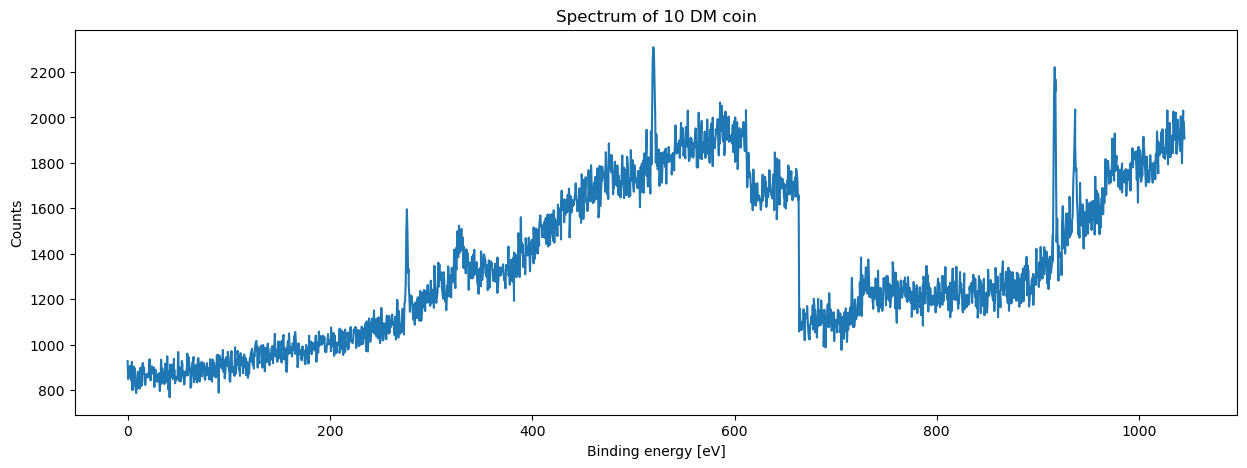

In [35]:
#df.plot('Energy(meas)', 'Sum')
# plt.show()

positive_mask = np.where(df['BindingEnergy'].to_numpy()>=0)

be = df['BindingEnergy'].to_numpy()[positive_mask]
count = df['Scan1'].to_numpy()[positive_mask]

fig = plt.figure(figsize=(15,5))
plt.plot(be,count)
plt.title('Spectrum of 10 DM coin')
plt.xlabel('Binding energy [eV]')
plt.ylabel('Counts')
plt.show()

The first pick corresponds to a binding energy of 276.2+-1.4


In [36]:
# Save nev csv file for spectra analisis

df[['Energy(meas)', 'Scan1']].to_csv('dati/Coin_MG_50V_binding1.csv', index=False)

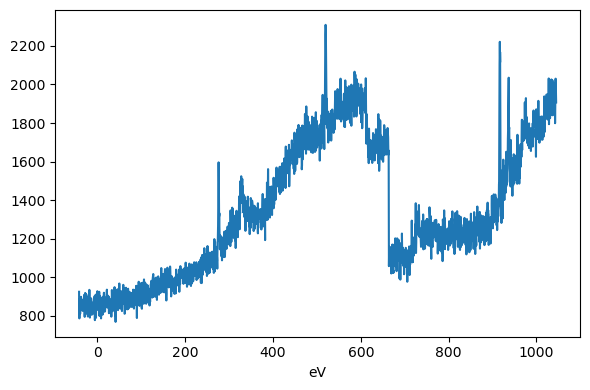

In [47]:
data = load_csv_datatype(df=df, energy_key='BindingEnergy', n_scans=1)

# Plot datas
fig, axes = plt.subplots(1, 1, figsize=(6,4))

#data.sum("eV").S.plot(ax=axes)
data.S.plot(ax=axes)

plt.tight_layout()

# Curve fitting 

First let's try just to fit the model without subtract the background 

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_31748/977624387.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['BindingEnergy'].between(930, 950, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,2592.137,-inf,inf,304.272,True,,
a_center,936.469,-inf,inf,0.327,True,,
a_fwhm,5.630,-inf,inf,0.750,False,2.3548200*a_sigma,
a_height,432.514,-inf,inf,50.964,False,"0.3989423*a_amplitude/max(1e-15, a_sigma)",
a_sigma,2.391,0.000,inf,0.319,True,,


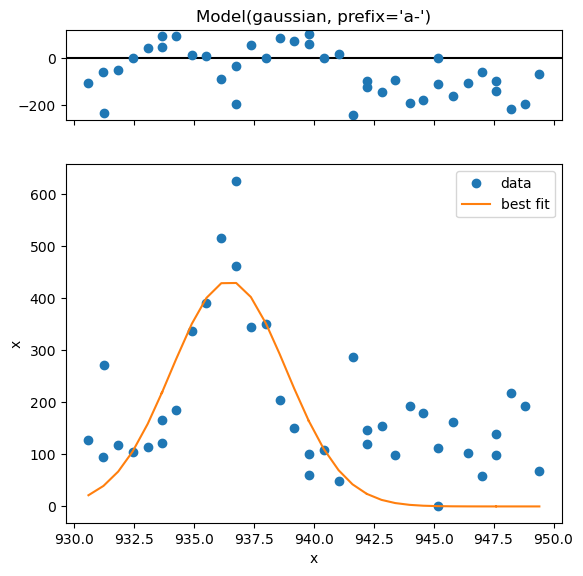

In [61]:
from arpes.fits.fit_models import GaussianModel, AffineBackgroundModel, LorentzianModel, VoigtModel
from arpes.analysis.shirley import remove_shirley_background, calculate_shirley_background_full_range
from arpes.fits.utilities import result_to_hints
#test_curve = data.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).sel(eV=slice(-36, -31))

# Selection
selection = df['BindingEnergy'].between(930, 950, inclusive=False).to_numpy()

test_curve = data.sel(eV=selection)
test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model =  GaussianModel(prefix="a_") #+ GaussianModel(prefix="b_")

result = test_model.guess_fit(
    test_curve - test_curve.min(),
    # params={
    #     "a_center": {"value": 653, "max":655, "min":651 },
    #     "a_amplitude": {"min": 0},
    #     "b_center": {"value": 683, "max":687, "min":680},
    #     "b_amplitude": {"min": 0},
    # }
)
result.plot()
result